# CS 109 Final Project
### StackExchange Tag Prediction

Dakota Diggs, Eric Hendey, Rajiv Tarigopula, Peter Wei

http://scholar.harvard.edu/rajiv/classes/materials/data-science-final-project

<img src="http://cdn.sstatic.net/stackexchange/img/logos/se/se-logo.png">



## Overview and Motivation
The goals of our project are to develop accurate classifiers for large-scale data analysis of a dataset composed of [Stack Exchange](www.stackexchange.com) posts.  Stack Exchange is a question-and-answer website network that covers topics in specific disciplines; for instance, Stack Overflow (a popular forum that is part of the network) is a very popular computer programming question-and-answer site.  The task given by the [Kaggle competition](http://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction) is to test our text analysis skills to predict the tags (a.k.a. keywords, topics, summaries) on a particular Stack Exchange post given only the question text and the title of the post itself.  

All four of us were interested in this project when we discovered the Kaggle competition, as we are all interested in large-scale text mining projects as an application of our data analysis skills, and felt that entering this competition would enable us to make a contribution in an important area of research.  We know that many have addressed tag prediction in the literature, but that the problem is still far from solved (otherwise, Facebook would not have sponsored this Kaggle competition for human capital recruiting purposes!) - please see below for some of the relevant academic literature that inspired us to tackle this challenge.

One of the challenges we faced in this project was dealing with the dataset itself.  Since the dataset contains content from disparate stack exchange sites (Stack Overflow, etc.), we had to deal with a corpus of text that contained a mix of both technical and non-technical questions.  As we will discuss, this was apparent when we viewed our output when experimenting with topic models.

##Related Work
Beyond the competitive aspect to this project, there was one paper in particular that inspired us to believe that there was significant promise in the task of predicting tags for StackOverflow posts.  This was a research report from Psychology and Computer Science professors Clayton Stanley and Michael D. Byrne of Rice University, entitled [“Predicting Tags for StackOverflow Posts.”]( http://chil.rice.edu/research/pdf/StanleyByrne2013StackOverflow.pdf)

In their paper, Professors Byrne and Stanley concisely summarize the task at hand and its promise in the field of data science: “Hashtags created by authors of online content provide a view of a user’s goals and interests.  Predicting users’ interests can lead to improved, more user centered human-computer systems.”

There are a few differences between the Rice professors’ methodology and our final methodology.  For one, the professors predicted one tag per post, while we experimented with the number of tags and in fact did some data exploration and investigation to see if there were any way to accurately predict the number of tags per post in our dataset, since this is a metric which we will be penalized for in f1-score (the Kaggle competition’s accuracy / success metric) if we incorrectly predict the number of tags.

Some other related academic papers that helped us along our way can be found in references [“Predicting Closed Questions on Stack Overflow”](http://home.iitk.ac.in/~prigoyal/cs671/project/report.pdf), [“Classification of Text Documents”](http://comjnl.oxfordjournals.org/content/41/8/537.short), and [“Labeled LDA: a supervised topic model for credit attribution in multi-labeled corpora”](http://dl.acm.org/citation.cfm?id=1699543).

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import string
import re
import operator

from time import time
from pylab import plot,show
from scipy import stats

from sklearn.cross_validation import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix
from sklearn import decomposition
from sklearn.grid_search import GridSearchCV

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

        


hello, world
5.0


## Data Overview

In terms of data, the StackExchange network is a group of question-and-answer website pages on topics in many different fields.  Each site covers a specific topic, and each question on the site pertains to key areas of interest.  The StackExchange dataset contains a large number of posts and associated tags, making it ideal for the problem of tag prediction on Kaggle.com.  

The facilitators of the competition collect a large sample of StackExchange network posts to provide to users. This a large file of several gigabytes and is the source of our data; it is organized in a .CSV file format.  Scraping was not an issue for us since we had the data already, but cleanup of the data was quite important.  Several of our Python scripts deal with correctly handling the data and, for instance, when a certain line of the data poses a problem, discarding that line.

Below, we import a subset of our training data for the purposes of the process book:

In [31]:
input_file = open("Train_Sample.csv",'r')
reader = csv.reader( input_file )
reader.next()

Text = []
Tags = [] 

i = 0

for line in reader:
    Text.append(str(line[1] + " " + line[2]))
    Tags.append(str(line[3]))
    i += 1
    if (i == 2000):
        break

input_file.close()

## Initial Questions and Exploratory Visualizations

Naturally, given the objective of the Kaggle competition, the primary question we are trying to answer is this: Can we predict a Stack Exchange post’s tags, given the title and text of that post?  

When we first proposed this project, there were several goals for what we would have liked to learn.  Understanding the user-based tagging of online content is an important and growing trend; the authors of posts on social media sites such as Twitter and Facebook create hashtags to categorize content.  These hashtags provide a view of a user's goals and interests, and have become almost ubiquitous in our daily digital lives.  Predicting users’ interests by modeling tag creation could significantly improve user experience, and systems could be created to introduce users to tags that are of interest to them or to identify and correct mistags or otherwise incorrect classifications.  

People in both academia and the technology world have been trying to attack this problem of text classification for years.  We hoped to synthesize their work and potentially come up with novel solutions;  additionally, the specific application to StackExchange data could pose challenges that other authors have not considered.

Over the course of the last few weeks as we have been exploring the dataset, we realize that our initial assumptions had to be modified a bit in order to deal with the realities of the dataset itself.  Several secondary questions emerged such with regard to effective dimensionality reduction via topic modeling, reliable prediction of the number of tags, and more.  In the end, the process had multiple stages, including data cleaning - which was very tough - with text data, predictive modeling, and model selection and tuning.

First, we wanted to understand some of the major characteristics of the dataset. We first took a look at the distribution of the tags that we were trying to predict:

number of tags in dataset = 2266


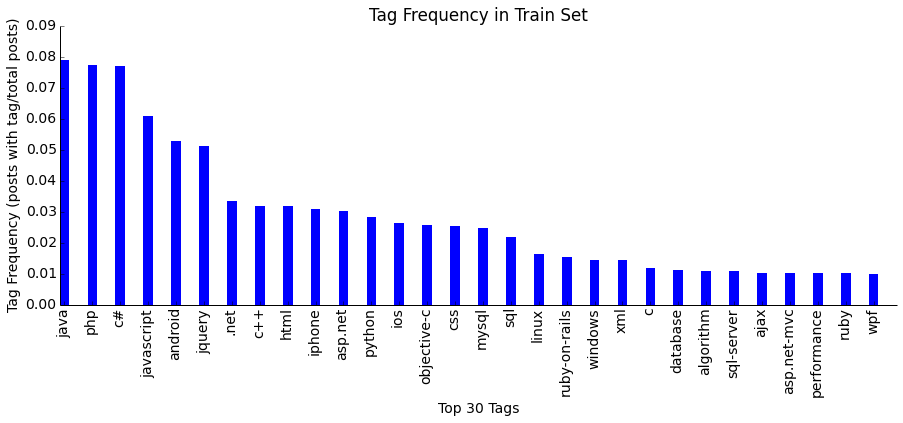

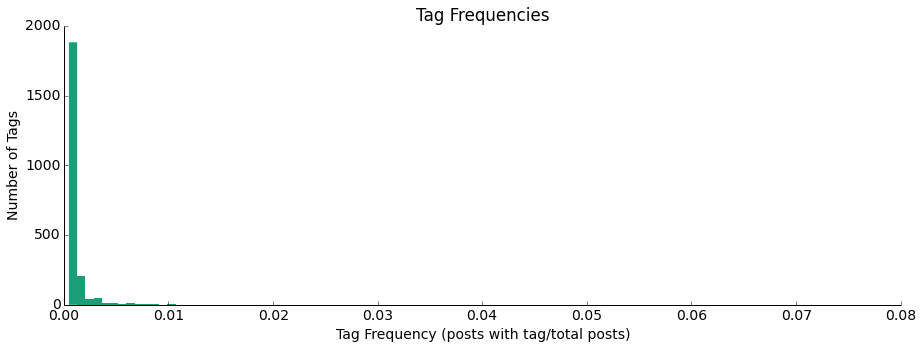

In [32]:
# this cell visualizes the tags

N = 30

Y_vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), min_df=0, binary=True)
Y = Y_vectorizer.fit_transform(Tags)
tags = Y_vectorizer.get_feature_names()

num_posts, num_words = Y.shape
print 'number of tags in dataset = %s' % num_words
counts = Y.sum(axis=0).tolist()[0]
word_counts = list(enumerate(counts))

sorted_word_counts = sorted(word_counts, key=lambda x: x[1], reverse=True)
sorted_word_counts = map(lambda x: (tags[x[0]], float(x[1])/num_posts), sorted_word_counts)

sorted_words, sorted_counts = zip(*sorted_word_counts)

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(15,5))
p1 = plt.bar(ind, sorted_counts[:N],  width)
plt.title('Tag Frequency in Train Set')
plt.xlabel('Top %s Tags' % N)
plt.ylabel('Tag Frequency (posts with tag/total posts)')
plt.xticks(ind+width/2., sorted_words[:N], rotation=90 )
plt.yticks(np.arange(0,.1,.01))
remove_border()
plt.show()

plt.figure(figsize=(15,5))
plt.hist(sorted_counts,bins=100)
plt.title('Tag Frequencies')
plt.xlabel('Tag Frequency (posts with tag/total posts)')
plt.ylabel('Number of Tags')
remove_border()
plt.show()


After looking at these graphs we noticed that the distribution of tags is extremely left skewed and sparse. No tag appears in more than 8% of the posts. The overwhelming majority of tags appear in less than 1% of the posts. To deal with this sparsity, we knew that we could need to filter out some of the tags with the lowest occurance. To accomplish this we used the CountVectorizer's "min_df" parameter in subsequent work.

It is also interesting to note that the most popular tags are the names of programming languages. This makes sense given our domain, StackOverflow.

Next, we conducted a similar analysis on the actual content of the posts, the words of each question. We dealt with the problem of sparsity by choosing to visualize only words that appeared in at least 5 posts, and also removed commonly-occurring "stop words" like "it" and "them".

number of words in dataset = 3009


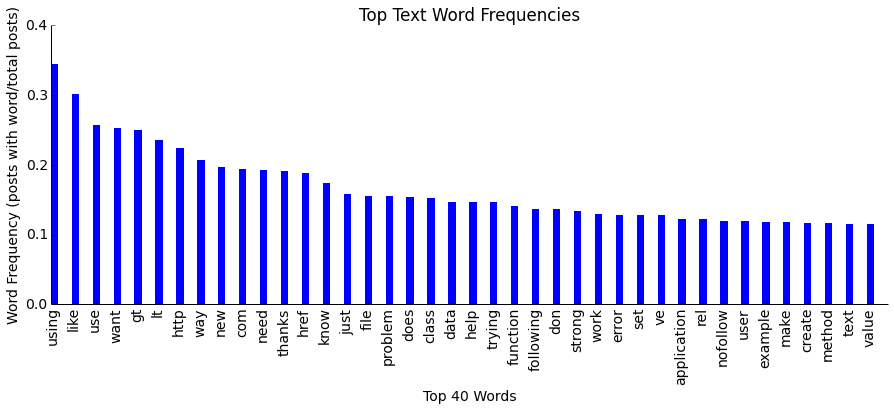

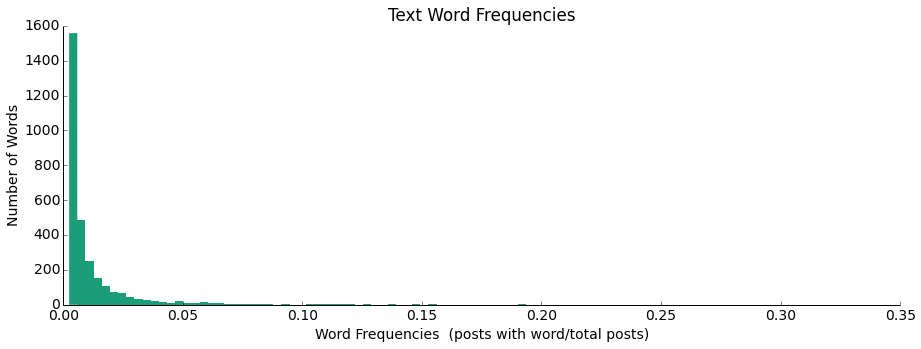

In [34]:
# code in this cell visualizes the words

N = 40

X_vectorizer = CountVectorizer(min_df = int(5), max_df=0.4, stop_words='english', binary=True)
X = X_vectorizer.fit_transform(Text)
words = X_vectorizer.get_feature_names()

num_posts, num_words = X.shape
print 'number of words in dataset = %s' % num_words
counts = X.sum(axis=0).tolist()[0]
word_counts = list(enumerate(counts))

sorted_word_counts = sorted(word_counts, key=lambda x: x[1], reverse=True)
sorted_word_counts = map(lambda x: (words[x[0]], float(x[1])/num_posts), sorted_word_counts)

sorted_words, sorted_counts = zip(*sorted_word_counts)

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(15,5))
p1 = plt.bar(ind, sorted_counts[:N],  width)
plt.title('Top Text Word Frequencies')
plt.xlabel('Top %s Words' % N)
plt.ylabel('Word Frequency (posts with word/total posts)')
plt.xticks(ind+width/2., sorted_words[:N], rotation=90 )
plt.yticks(np.arange(0,.5,.1))
remove_border()
plt.show()

plt.figure(figsize=(15,5))
plt.hist(sorted_counts,bins=100)
plt.title('Text Word Frequencies')
plt.xlabel('Word Frequencies  (posts with word/total posts)')
plt.ylabel('Number of Words')
remove_border()
plt.show()


The words obviously exhibit a similar sparsity, with the majority occuring in less than 1% of all posts. Additionally, those that do appear more commonly do not tell us very much about the content of the post; words like "using", "want", and "thanks". Factors like this, we hypothesized would add to the difficulty in extracting signal from such a noisy set of data.

Next, we visualized the number of tags assigned to each post, and found that all posts have between 1 and 5 tags:

average number of tags per post in dataset = 2.9355


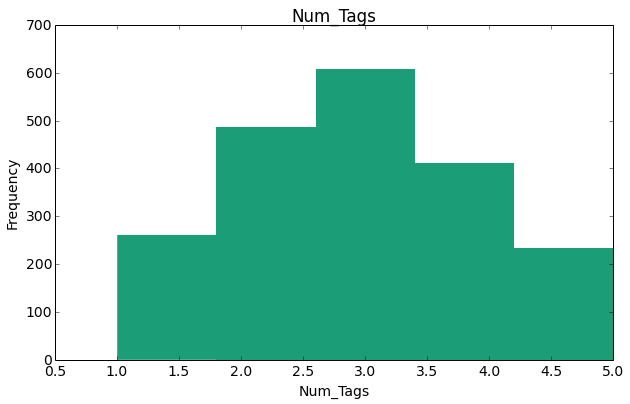

In [69]:
Num_Tags = [(x.count(' ') + 1) for x in Tags]

print 'average number of tags per post in dataset = %s' % np.mean(Num_Tags)

fig1 = plt.figure()
plt.hist(Num_Tags, bins = 5)
plt.title("Num_Tags")
plt.xlabel("Num_Tags")
plt.ylabel("Frequency")
plt.show()


We felt that accurately predicting the number of tags assigned to a post may be an important performance-enchancing aspect of our work. Later in the process notebook, we detail our work along this line of inquiry.

Below, to visualize the most prominent words in the dataset in another way, we have included a wordcloud:

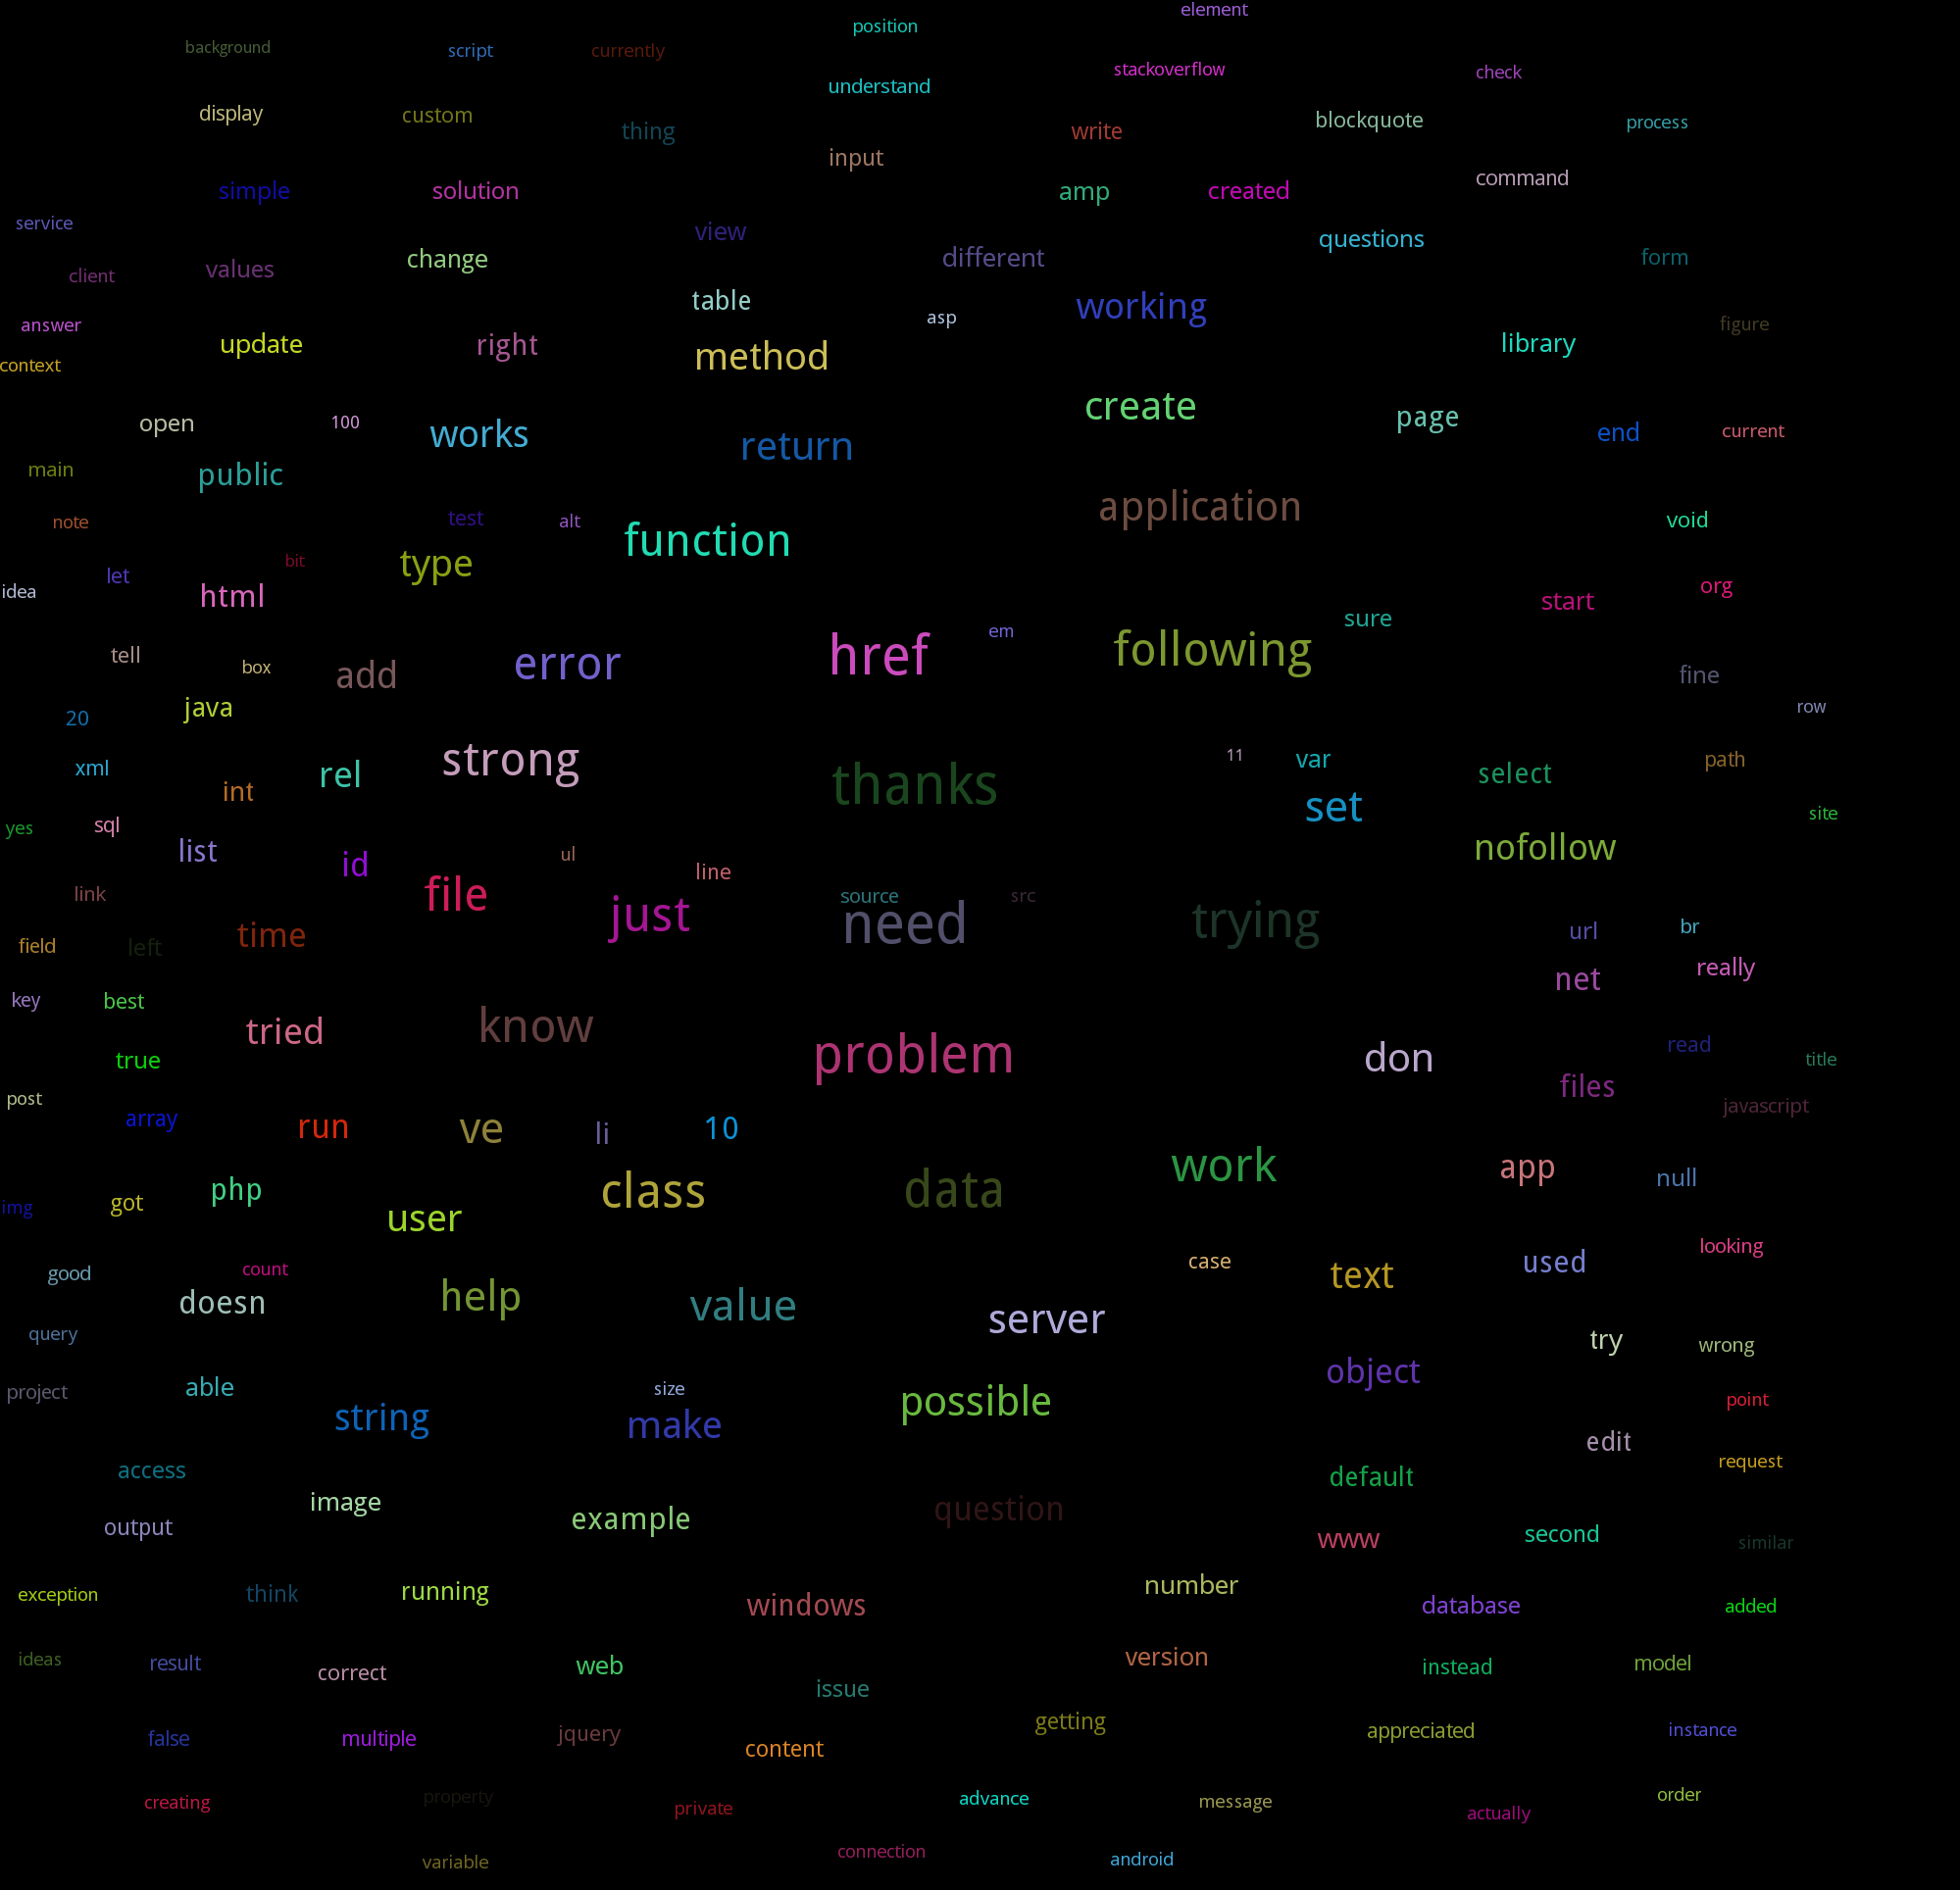

In [59]:
'''
from pytagcloud import create_tag_image, make_tags, LAYOUT_HORIZONTAL, LAYOUTS
from pytagcloud.lang.counter import get_tag_counts

def make_me_a_word_cloud(string_list):
    YOUR_TEXT = ' '.join(string_list)
    tags = make_tags(get_tag_counts(YOUR_TEXT), maxsize=50)
    create_tag_image(tags, 'cloud_large.png', size=(2000, 2000), background=(0, 0, 0, 255), 
                         layout=5, fontname='Droid Sans')


X_vectorizer = CountVectorizer(min_df = int(5), max_df=0.2, stop_words='english', binary=True)
X = X_vectorizer.fit_transform(Text)
words = X_vectorizer.get_feature_names()

num_posts, num_words = X.shape

counts = X.sum(axis=0).tolist()[0]
word_counts = list(enumerate(counts))

sorted_word_counts = sorted(word_counts, key=lambda x: x[1], reverse=True)
sorted_word_counts = map(lambda x: (words[x[0]], x[1]), sorted_word_counts)
#print sorted_word_counts

mystrlist = []
for i in range(200):
    x = [sorted_word_counts[i][0]] * sorted_word_counts[i][1]
    mystrlist += x
'''

#make_me_a_word_cloud(mystrlist)
#print mytext
from IPython.core.display import Image 
Image(filename='top200words.png') 

Given what we learned about the dataset from these visualizations, we developed two further initial questions, which we develop later in the process book.

   1. Given the sparsity of the dataset, is dimensionality reduction via topic modeling effective in solving this problem?
   2. Can the number of tags be predicted reliably?

## Analysis and Results

We initially approached the problem as a "multilabel" classification problem, where we trained individual classifiers for each tag. This algorithm is known as "One vs. Rest", because it is used to distinguish one class from all others. 

The python lbrary [scikitlearn](http://scikit-learn.org/stable/index.html) included many functions which made analysis of text data much easier. First, it allowed us to operate on a vectorized representation of the text data. Additionally, it allowed us to test a number of classifiers. Finally, it provided us with implementations for dimensionality reduction tools.

Below, we define functions to convert the text and tags into vectorized representations, X and Y.

One important note is our choice of "Term frequency-inverse document frequency" (tf-idf) as the representation for the text (X) data. Tf-idf is a numerical statistic that reflects how important a word is in the context of the documents or corpus.  As different scholars have [described it](http://i.stanford.edu/~ullman/mmds/ch1.pdf), tf-idf is often used to in the context information retrieval and text mining.  The metric increases proportionately to the number of times a word appears in a document, but it is offset by the frequency of the word in the entire corpus of text, which is a control variable for the fact that some words are generally more common than others.


In [21]:
"""
    Function
    --------
    my_tokenizer(s)

    Takes input s and splits based on spaces rather than both spaces and punctuation.
    
    Parameters
    ----------
    
    s : str
        The string of input text
    
    Returns
    -------
    The split list as defined above.
    
"""
def my_tokenizer(s):
    return s.split()


"""
    Function
    --------
    makeX(Text, X_min_df)

    Converts Text to vectorized representation X
    
    Parameters
    ----------
    
    Text : list
        The list of strings of input text
    
    X_min_df : float or int
        The number corresponding to the percent of posts which we want (int for a minimum number of posts)
    
    Returns
    -------
    A tuple of the sparse COO matrix X (the vectorized representation of the text) and X_vectorizer (which accomplished the vectorizing)
    
"""
def makeX(Text,X_min_df=.0001):
    X_vectorizer = TfidfVectorizer(min_df = X_min_df, sublinear_tf=True, max_df=0.9,stop_words='english')
    X = X_vectorizer.fit_transform(Text)
    return coo_matrix(X), X_vectorizer

"""
    Function
    --------
    makeY(Tags, Y_min_df)

    Converts Tags to vectorized representation Y
    
    Parameters
    ----------
    
    Text : list
        The list of strings of input text
    
    Y_min_df : float or int
        The number corresponding to the percent of posts which we want (int for a minimum number of posts)
    
    Returns
    -------
    A tuple of the matrix Y (the vectorized representation of the tags) and Y_vectorizer (which accomplished the vectorizing)
    
"""

def makeY(Tags, Y_min_df=.0001):
    Y_vectorizer = CountVectorizer(tokenizer = my_tokenizer, min_df = Y_min_df, binary = True)
    Y = Y_vectorizer.fit_transform(Tags)
    return Y, Y_vectorizer

The functions below convert the outputs of various classifiers to predictions for the number of tags. Some classifiers make predictions based on a "decision function", while others compute probabilities for how likely class membership is.

In [22]:
"""
    Function
    --------
    df_to_preds(dfmatrix, k)

    Takes input dfmatrix and returns the matrix of predicted tags.
    
    Parameters
    ----------
    
    dfmatrix : matrix
        Decision function outputs in matrix form
        
    k : int
        Number of tags to predict
    
    Returns
    -------
    The matrix of predicted tags.
    
"""
def df_to_preds(dfmatrix, k = 5):
    predsmatrix = np.zeros(dfmatrix.shape)
    for i in range(0, dfmatrix.shape[0]):
        dfs = list(dfmatrix[i])
        if (np.sum([int(x > 0.0) for x in dfs]) <= k):
            predsmatrix[i,:] = [int(x > 0.0) for x in dfs]
        else:
            maxkeys = [x[0] for x in sorted(enumerate(dfs),key=operator.itemgetter(1),reverse=True)[0:k]]
            listofzeros = [0] * len(dfs)
            for j in range(0, len(dfs)):
                if (j in maxkeys):
                    listofzeros[j] = 1
            predsmatrix[i,:] = listofzeros
    return predsmatrix

"""
    Function
    --------
    probs_to_preds(probsmatrix, k)

    Takes input probsmatrix and returns the matrix of predicted tags.
    
    Parameters
    ----------
    
    probsmatrix : matrix
        Probability outputs in matrix form
        
    k : int
        Number of tags to predict
    
    Returns
    -------
    The matrix of predicted tags.
    
"""
def probs_to_preds(probsmatrix, k = 5):
    predsmatrix = np.zeros(probsmatrix.shape)
    for i in range(0, probsmatrix.shape[0]):
        probas = list(probsmatrix[i])
        if (np.sum([int(x > 0.01) for x in probas]) <= k):
            predsmatrix[i,:] = [int(x > 0.01) for x in probas]
        else:
            maxkeys = [x[0] for x in sorted(enumerate(probas),key=operator.itemgetter(1),reverse=True)[0:k]]
            listofzeros = [0] * len(probas)
            for j in range(0, len(probas)):
                if (j in maxkeys):
                    listofzeros[j] = 1
            predsmatrix[i,:] = listofzeros
    return predsmatrix

Our success metric for this project is to try and maximize the Mean F1 score. The F1 score measures accuracy using the statistics precision (p) and recall (r). It thus measures both accuracy and the ability to make a large number of positive predictions. The F1 score is given by:

F1 = 2(p⋅r)/(p+r),  where p = tp/(tp+fp),  r = tp/(tp+fn)


Kaggle also [notes](http://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction) that "the F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other."

To prevent overfitting, as well as to determine the optimal parameters for each classifier we tested, we implemented the following routine to preform a 'grid search' cross-validation. This method measures validated Mean F1 score for a given classifier for each possible combination of parameters we are interested in testing, and returns the best set of parameters.

In [24]:
"""
    Function
    --------
    opt_params(clf_current, params)

    Determines the set of parameters for clf_current that maximize cross-validated F1 score using sklearn's GridSearchCV
    
    Parameters
    ----------
    
    clf_current : scikitlearn clf object
        the clf we want to test
        
    params: list
        list of parameters that we will want to tune for
    
    Returns
    -------
    A tuple of the classifier's description, the score, the time it took to train, and the time it took to test.
    
"""

def opt_params(clf_current, params):
    model_to_set = OneVsRestClassifier(clf_current)
    grid_search = GridSearchCV(model_to_set, param_grid=params, score_func=metrics.f1_score)

    print("Performing grid search on " + str(clf_current).split('(')[0])
    print("parameters:")
    print(params)
    grid_search.fit(X_train, Y_train.toarray())
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    gs = grid_search.grid_scores_
    ret = [(i[0], i[1]) for i in gs]
    return best_parameters, ret


Finally, this function determines how well a given classifier performs on the test set:

In [58]:
"""
    Function
    --------
    benchmark(clf_current)

    Takes the classifier passed and determines how well it performs on the test set.
    
    Parameters
    ----------
    
    clf_current : scikitlearn clf object
    
    Returns
    -------
    A tuple of the classifier's description, the score, the time it took to train, and the time it took to test.
    
"""

def benchmark(clf_current):
    print('_' * 80)
    print("Test performance for: ")
    clf_descr = str(clf_current).split('(')[0]
    print(clf_descr)
    t0 = time()
    classif = OneVsRestClassifier(clf_current)
    classif.fit(X_train, Y_train.toarray())
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    t0 = time()
    if hasattr(clf_current,"decision_function"):
        dfmatrix = classif.decision_function(X_test)
        score = metrics.f1_score(Y_test.toarray(), df_to_preds(dfmatrix, k = 5))
    else:
        probsmatrix = classif.predict_proba(X_test)
        score = metrics.f1_score(Y_test.toarray(), probs_to_preds(probsmatrix, k = 5))
        
    test_time = time() - t0

    
    print("f1-score:   %0.7f" % score)
    print("test time:  %0.3fs" % test_time)

    print('_' * 80)
    return clf_descr, score, train_time, test_time




###Classifier Performance on the Tf-idf Vector

One major conclusion reached was that given this corpus of text and title data, certain algorithms and classifiers that we use are better suited than others to predict the specific tags in this data set.  Therefore, in these stages of analysis, we try to optimize for the best classifier on this text domain.

The below cell optimizes parameters for a list of classifiers and outputs test performance for each on the F1 score. We have tested multiple classifiers including Naive Bayes, Stochastic Gradient Descent classifiers, linear SVC classifiers, a passive aggressive classifier, and a perceptron.

In [38]:
import warnings
warnings.filterwarnings("ignore")

Y, vectorizer2 = makeY(Tags, Y_min_df=int(10))
X, vectorizer1 = makeX(Text, X_min_df=int(10))
X_current = X
X_train, X_test, Y_train, Y_test = train_test_split(X_current,Y)

results = []
classlist = [
(Perceptron(), {'estimator__penalty': ['l1', 'elasticnet'],"estimator__alpha":[.001,.0001],'estimator__n_iter':[50]}), 
(PassiveAggressiveClassifier(), {'estimator__C':[.01,.1,1.0],'estimator__n_iter':[50]}),
(LinearSVC(), {'estimator__penalty': ['l1','l2'], 'estimator__loss': ['l2'],'estimator__dual': [False], 'estimator__tol':[1e-2,1e-3]}),
(SGDClassifier(), {'estimator__penalty': ['l1', 'elasticnet'],"estimator__alpha":[.0001,.001],'estimator__n_iter':[50]}),
(MultinomialNB(), {"estimator__alpha":[.01,.1],"estimator__fit_prior":[True, False]}),
(BernoulliNB(), {"estimator__alpha":[.01,.1],"estimator__fit_prior":[True, False]})
            ]

for classifier, params_to_optimize in classlist:
    best_params, gs = opt_params(classifier, params_to_optimize)
    results.append(benchmark(best_params['estimator']))

    

Performing grid search on Perceptron
parameters:
{'estimator__alpha': [0.001, 0.0001], 'estimator__penalty': ['l1', 'elasticnet'], 'estimator__n_iter': [50]}
()
Best score: 0.410
Best parameters set:
	estimator__alpha: 0.0001
	estimator__n_iter: 50
	estimator__penalty: 'l1'
________________________________________________________________________________
Test performance for: 
Perceptron
f1-score:   0.3836243
________________________________________________________________________________
Performing grid search on PassiveAggressiveClassifier
parameters:
{'estimator__n_iter': [50], 'estimator__C': [0.01, 0.1, 1.0]}
()
Best score: 0.403
Best parameters set:
	estimator__C: 0.1
	estimator__n_iter: 50
________________________________________________________________________________
Test performance for: 
PassiveAggressiveClassifier
f1-score:   0.3794511
________________________________________________________________________________
Performing grid search on LinearSVC
parameters:
{'estimator_

The plot below shows results for each calssifier. Pay particular attention to the red bar, which denotes F1 score.

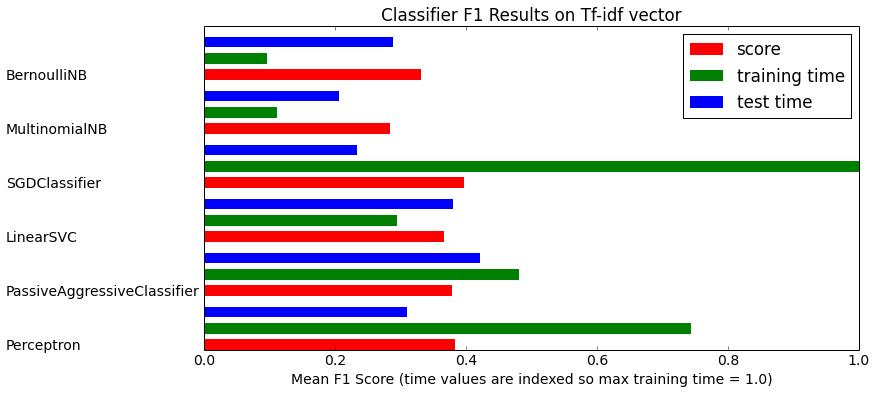

In [50]:
"""
    Function
    --------
    plot_results(current_results)

    Takes results of benchmarking function and plot
    
    Parameters
    ----------
    
    current_results : list
        Output of the benchmark function
    
    title : str
        The title for the plot
    
    Returns
    -------
    None
    
"""

# make some plots
def plot_results(current_results, title = "Score"):
    indices = np.arange(len(current_results))
    
    results2 = [[x[i] for x in current_results] for i in range(4)]
    
    clf_names, score, training_time, test_time = results2
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(training_time)
    
    plt.figure(1, figsize=(14,5))
    plt.title(title)
    plt.barh(indices, score, .2, label="score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.xlabel('Mean F1 Score (time values are indexed so max training time = 1.0)')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    
    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    
    plt.show()
    
plot_results(results, title = "Classifier F1 Results on Tf-idf vector")

Several of the classifiers achieve strong performance, approaching an F1 score of 0.4. 

The absolute strongest performance is from the SGD classifier. The SGD classifier uses the popular machine learning tool of stochastic gradient descent or SGD. It is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions, such as linear support vector machines and logistic regression.  Even though SGD has been around in the machine learning community for a long time, it is receiving a considerable amount of attention recently in the context of large-scale learning.  As such, we have seen it will be greatly applicable to the text and data analysis in this project.  SGD has been [successfully applied](http://scikit-learn.org/stable/modules/sgd.html) to large-scale and sparse machine learning problems often encountered in text classification, for instance.  Since we are working with sparse matrices, we believe that the use of stochastic gradient descent classifier methods will give us great advantages, including efficiency and ease of implementation.  As we see from some of our visualizations regarding the most common words, the top words are some of the most frequently used words in the English language, indicating that our classifiers must be particularly good at extracting the signal from the noise.

It is important to note however that this strong performance comes at the expense of having the longest training time of all algorithms studied.

### Topic Modeling and Dimensionality Reduction

Here we show classification performance based on the output of latent semantic analysis, which models topics and reduces dimensionality. We felt that dimensonality reduction may enable us to increase performance by removing noise from the data.

We tried LSA using two methods of decomposition. Both latent semantic analysis using singular value decomposition (svd) and latent semantic analysis using nonnegative matrix factorization (nmf), are similar methods of dimensionality reduction, but they optimize the same objective function through different means, as [various researchers](http://ezcodesample.com/plsaidiots/DingLiPeng06.pdf) have shown - including Chris Ding at the Lawrence Berkeley National Laboratory in Berkeley California.  Basically, all NMF does is add the constraint that the elements in the decomposed matrices have to be non-negative.

The below defines function for transforming a vectorized representation of words to a vectorized representation of topics.

In [51]:

"""
    Function
    --------
    topic_transform(X, n_topics)

    Takes input X (defined above, output of makeX function) and performs either non-negative matrix factorization or singular value decomposition to get the number of topics.
    
    Parameters
    ----------
    
    X : matrix
        See above
    
    n_topics : int
        Number of topics to output.
    
    method : string
        either "SVD" or "NMF". Defaults to "SVD"
    
    Returns
    -------
    The transformed data.
    
"""
def topic_transform(X, n_topics = 10, method = "SVD"):
    if (method == "NMF"):
        topics = decomposition.NMF(n_components=n_topics).fit(X)
    else:
        topics = decomposition.TruncatedSVD(n_components=n_topics).fit(X)
    X_topics = topics.transform(X)
    for i in range(0,X_topics.shape[0]):
        theline = list(X_topics[i])
        # following line is only important for SVD
        theline = [(x * int(x > 0)) for x in theline]
        topic_sum = np.sum(theline)
        X_topics[i] = list(np.divide(theline,topic_sum))
    return X_topics, topics


"""
    Function
    --------
    print_topics(topics,vectorizer1,n_top_words = 12)

    Print the top words for each topic
    
    Parameters
    ----------
    
    topics : TruncatedSVD output
        comes from the above function "topic_transform"
    
    vectorizer1 : vectorizer
        Vectorizer for the X matrix
    
    n_top_words : int
        print this many words
    
    Returns
    -------
    None
    
"""

def print_topics(topics,vectorizer1,n_top_words = 12):
    # Inverse the vectorizer vocabulary to be able
    feature_names = vectorizer1.get_feature_names()
    
    for topic_idx, topic in enumerate(topics.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()



Here are some examle output topics for LSA using NMF for decomposition:

In [52]:
X_nmf, nmf = topic_transform(X, n_topics = 20,method = "NMF")
print_topics(nmf,vectorizer1)

Topic #0:
gt lt code pre id type xml value br td tr input
()
Topic #1:
http com href rel nofollow www org en stackoverflow https html questions
()
Topic #2:
table select query database insert sql column values row rows data id
()
Topic #3:
li ul ol list menu following better best things points threads applications
()
Topic #4:
image img alt imgur src png stack com enter description http jpg
()
Topic #5:
public string new int class return void object null private static method
()
Topic #6:
server windows machine access sql client connection database connect linux port running
()
Topic #7:
function var jquery javascript document script alert json ajax event window type
()
Topic #8:
strong em blockquote br possible edit questions duplicate mode frac question stackoverflow
()
Topic #9:
10 00 12 11 date 20 15 01 30 03 14 16
()
Topic #10:
file files folder jar text directory using path xml read upload download
()
Topic #11:
android app application textview layout_height activity layout_width

Additionally, here are topics when we switch to using SVD.

In [54]:
X_svd, svd = topic_transform(X, n_topics = 20,method = "SVD")
print_topics(svd,vectorizer1)

Topic #0:
code pre gt lt using http like new strong com function use
()
Topic #1:
gt lt pre id div code value class string public type int
()
Topic #2:
http com href rel lt nofollow div gt html www page css
()
Topic #3:
com http public href nofollow rel pre code string www int void
()
Topic #4:
li android lt java gt ul file xml public class ol application
()
Topic #5:
li ul ol strong table list img em color code left alt
()
Topic #6:
li gt table database sql query lt ul server select value blockquote
()
Topic #7:
android table database id user view image public select sql application query
()
Topic #8:
file image img imgur png alt code stack table src strong files
()
Topic #9:
li data php file ul url ol pre server form database error
()
Topic #10:
android xml app php array like want iphone know number file textview
()
Topic #11:
android strong function server 10 windows run app pre error frac blockquote
()
Topic #12:
strong code pre em net view asp self mvc controller class user
()
Top

Both topic models yield some intuitive results. From this, it's easy to see that our topics are very interesting for the most part; most gave the sense that a specific post is about a specific question or a concept within the field of computer programming, for instance.  There are a few topics, however, that seem to be gibberish.

Now, we show how each method of decomposition fares when we learn classifiers based on its output.

Performing grid search on Perceptron
parameters:
{'estimator__alpha': [0.001, 0.0001], 'estimator__penalty': ['l1', 'elasticnet'], 'estimator__n_iter': [50]}
()
Best score: 0.166
Best parameters set:
	estimator__alpha: 0.001
	estimator__n_iter: 50
	estimator__penalty: 'l1'
________________________________________________________________________________
Test performance for: 
Perceptron
f1-score:   0.1647451
________________________________________________________________________________
Performing grid search on PassiveAggressiveClassifier
parameters:
{'estimator__n_iter': [50], 'estimator__C': [0.01, 0.1, 1.0]}
()
Best score: 0.158
Best parameters set:
	estimator__C: 1.0
	estimator__n_iter: 50
________________________________________________________________________________
Test performance for: 
PassiveAggressiveClassifier
f1-score:   0.1768675
________________________________________________________________________________
Performing grid search on LinearSVC
parameters:
{'estimator__

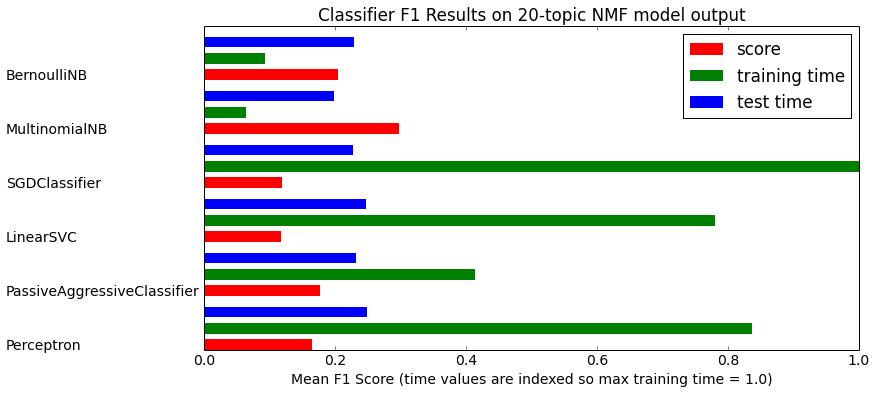

In [55]:
results_nmf = []
X_current = X_nmf
X_train, X_test, Y_train, Y_test = train_test_split(X_current,Y)

for classifier, params_to_optimize in classlist:
    best_params, gs = opt_params(classifier, params_to_optimize)
    results_nmf.append(benchmark(best_params['estimator']))

plot_results(results_nmf, title = "Classifier F1 Results on 20-topic NMF model output")

Performing grid search on Perceptron
parameters:
{'estimator__alpha': [0.001, 0.0001], 'estimator__penalty': ['l1', 'elasticnet'], 'estimator__n_iter': [50]}
()
Best score: 0.242
Best parameters set:
	estimator__alpha: 0.0001
	estimator__n_iter: 50
	estimator__penalty: 'l1'
________________________________________________________________________________
Test performance for: 
Perceptron
f1-score:   0.2126740
________________________________________________________________________________
Performing grid search on PassiveAggressiveClassifier
parameters:
{'estimator__n_iter': [50], 'estimator__C': [0.01, 0.1, 1.0]}
()
Best score: 0.165
Best parameters set:
	estimator__C: 1.0
	estimator__n_iter: 50
________________________________________________________________________________
Test performance for: 
PassiveAggressiveClassifier
f1-score:   0.1640178
________________________________________________________________________________
Performing grid search on LinearSVC
parameters:
{'estimator_

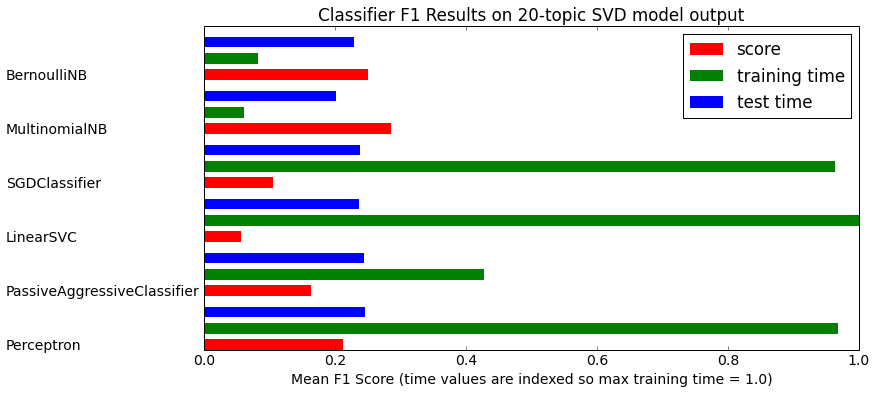

In [56]:
results_svd = []

X_current = X_svd
X_train, X_test, Y_train, Y_test = train_test_split(X_current,Y)

for classifier, params_to_optimize in classlist:
    best_params, gs = opt_params(classifier, params_to_optimize)
    results_svd.append(benchmark(best_params['estimator']))

plot_results(results_svd, title = "Classifier F1 Results on 20-topic SVD model output")

Neither method performed particularly well when compared to learning based on tf-idf. Additionally, Naive Bayes seemed to have the strongest performance here rather than the SGD Classifier.

In [57]:
nmf_results = []
svd_results = []

classif_tuple = SGDClassifier(), {'estimator__penalty': ['l1'],"estimator__alpha":[.0001,.001],'estimator__n_iter':[50]}

num_topics_list = [10,20,30,40,50,60,70,80,90,100]
for num_topics in num_topics_list:
    print 'Now testing for NMF with ' + str(num_topics) + ' topics'
    X_nmf, nmf = topic_transform(X, n_topics = num_topics, method = "NMF")
    X_current = X_nmf
    X_train, X_test, Y_train, Y_test = train_test_split(X_current,Y)
    nmf_results.append(benchmark(SGDClassifier(penalty = 'l1',alpha = .0001, n_iter = 50))[1])
    
    print 'Now testing for SVD with ' + str(num_topics) + ' topics'
    X_svd, svd = topic_transform(X, n_topics = num_topics, method = "SVD")
    X_current = X_svd
    X_train, X_test, Y_train, Y_test = train_test_split(X_current,Y)
    svd_results.append(benchmark(SGDClassifier(penalty = 'l1',alpha = .0001, n_iter = 50))[1])
    

Now testing for NMF with 10 topics
________________________________________________________________________________
Test performance for: 
SGDClassifier
f1-score:   0.0292654
________________________________________________________________________________
Now testing for SVD with 10 topics
________________________________________________________________________________
Test performance for: 
SGDClassifier
f1-score:   0.0202813
________________________________________________________________________________
Now testing for NMF with 20 topics
________________________________________________________________________________
Test performance for: 
SGDClassifier
f1-score:   0.0667475
________________________________________________________________________________
Now testing for SVD with 20 topics
________________________________________________________________________________
Test performance for: 
SGDClassifier
f1-score:   0.0963945
_________________________________________________________

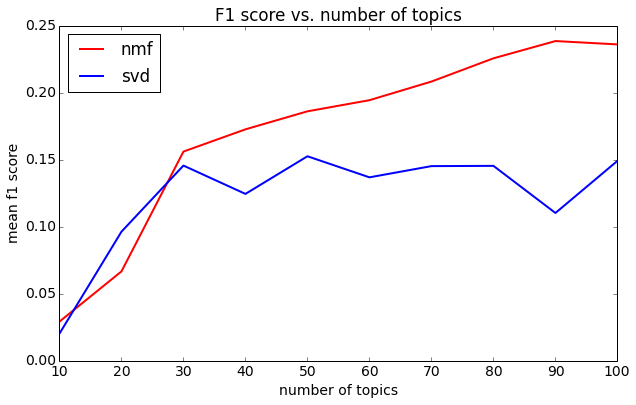

In [62]:
plt.plot(num_topics_list,nmf_results,'r',label="nmf")
plt.plot(num_topics_list,svd_results,'b',label="svd")
plt.legend(loc='best')
plt.ylabel('mean f1 score')
plt.xlabel('number of topics')
plt.title('F1 score vs. number of topics')

LSA using NMF led to stronger performance than using SVD for the most part, but was still not as strong as the tf-idf. Additionally, performance increased as number of topics increased. However, we did not want to increase the number of topics past 100, as the goal of dimensionality reduction was to simplify the input space.

### Predicting number of tags

Our group next attempted to predict number of tags, but our efforts did not prove to be very useful. We felt that the one method that achieved a reliable R-squared value likely overfit.

average number of tags per post in dataset = 2.9355


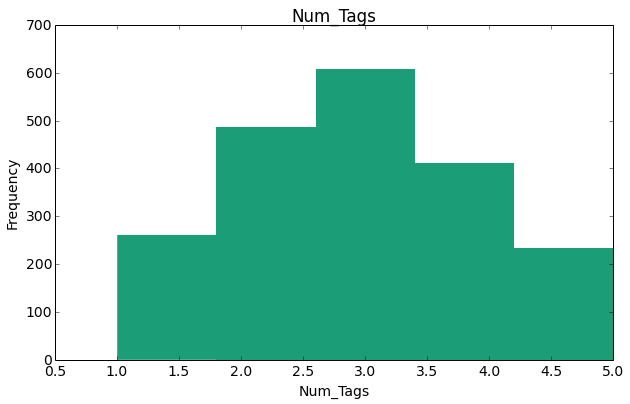

In [63]:
Num_Tags = [(x.count(' ') + 1) for x in Tags]

print 'average number of tags per post in dataset = %s' % np.mean(Num_Tags)

fig1 = plt.figure()
plt.hist(Num_Tags, bins = 5)
plt.title("Num_Tags")
plt.xlabel("Num_Tags")
plt.ylabel("Frequency")
plt.show()

We posited that there may be a link between post length in characters and number of tags. However, even after log-normalizing, we did not see much of a relationship.

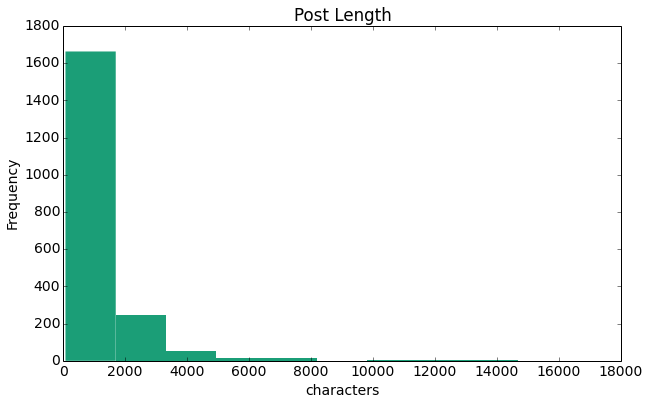

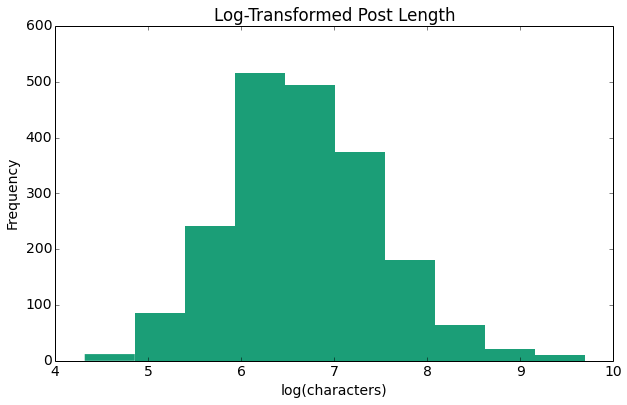

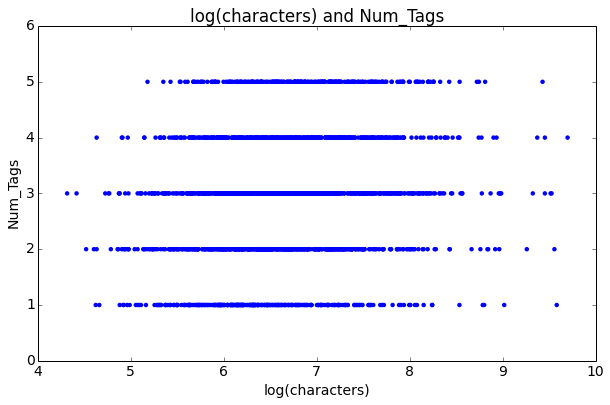

In [64]:
Lens = [(len(x) + 1) for x in Text]

fig2 = plt.figure()
plt.hist(Lens)
plt.title("Post Length")
plt.xlabel("characters")
plt.ylabel("Frequency")
plt.show()

fig3 = plt.figure()
plt.hist(np.log(Lens))
plt.title("Log-Transformed Post Length")
plt.xlabel("log(characters)")
plt.ylabel("Frequency")
plt.show()

fig4 = plt.figure()
plt.scatter(np.log(Lens), Num_Tags)
plt.title("log(characters) and Num_Tags")
plt.xlabel("log(characters)")
plt.ylabel("Num_Tags")
plt.show()


We implemented three linear regression models to try to predict number of tags. The regression on the tf-idf vector yielded a stron R-squared value, but we expect that it heavily overfit.

r-squared for regression against log(post length)
0.0292767614678
r-squared for regression against nmf vector
0.0655275462889
r-squared for regression against tf-idf vector
0.840769674323


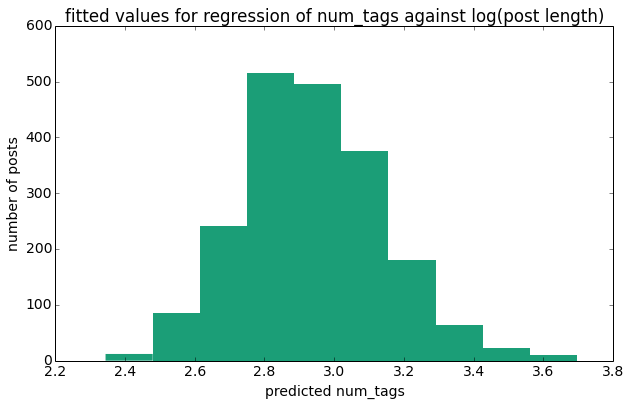

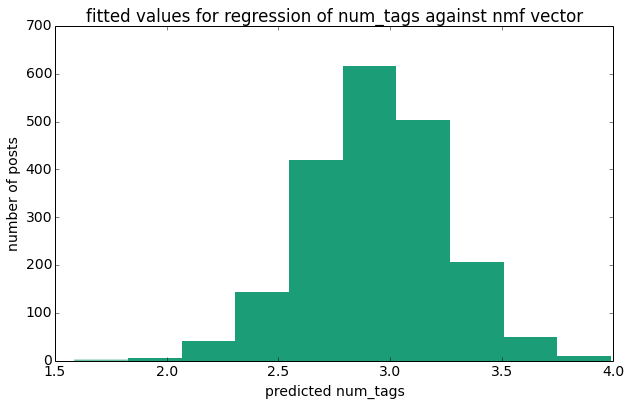

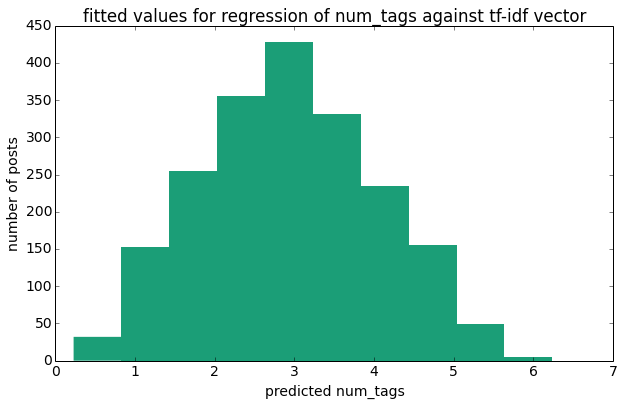

In [68]:
from sklearn.linear_model import LinearRegression
from scipy.stats.stats import pearsonr

logLens = np.log(Lens)

logLens = np.array(logLens).reshape(-1, 1)

regress = LinearRegression()
regress.fit(logLens, Num_Tags)
thepreds = list(regress.predict(logLens))

plt.figure(1)
plt.hist(thepreds)
plt.xlabel('predicted num_tags')
plt.ylabel('number of posts')
plt.title('fitted values for regression of num_tags against log(post length)')

print 'r-squared for regression against log(post length)'
print pearsonr(thepreds,Num_Tags)[0]**2

regress = LinearRegression()
regress.fit(X_nmf, Num_Tags)
thepreds = list(regress.predict(X_nmf))

plt.figure(2)
plt.hist(thepreds)
plt.xlabel('predicted num_tags')
plt.ylabel('number of posts')
plt.title('fitted values for regression of num_tags against nmf vector')

print 'r-squared for regression against nmf vector'
print pearsonr(thepreds,Num_Tags)[0]**2

regress = LinearRegression()
regress.fit(X, Num_Tags)
thepreds = list(regress.predict(X))

plt.figure(3)
plt.hist(thepreds)
plt.xlabel('predicted num_tags')
plt.ylabel('number of posts')
plt.title('fitted values for regression of num_tags against tf-idf vector')

print 'r-squared for regression against tf-idf vector'
print pearsonr(thepreds,Num_Tags)[0]**2


Because we had a difficult time predicting number of tags, we simply capped the number of tags we predicted at 5.

## Final Analysis

In the final analysis, we learned a great deal about the dataset that we were given for this competition and the ultimate subset of the data so that we decided to use for data analysis.  We had a few questions at the start of this project, of which the most important was: “Can we predict a Stack Exchange post’s tags, given the title and text of that post?”

The answer to this question is both yes and no.  We can indeed predict a particular post’s tags if we have a good sense of how many tags that post should have and the general content of that post.  However, the number of times is a difficult quantity to find, as our initial regressions show, and a metric that measures the confidence we have of the content of the post is also quite difficult to calculate.   As we hypothesized, SGD Classifier was indeed the one that had the best performance.

---
*css tweaks in this cell*
<style>
div.text_cell_render {
    line-height: 150%;
    font-size: 110%;
    width: 800px;
    margin-left:50px;
    margin-right:auto;
    }
</style>